In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from bayesmixpy import run_mcmc

In [3]:
%load_ext rpy2.ipython

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [4]:
df = pd.read_csv("/Users/marioberaha/Downloads/Y.csv")
y = df.V1.values

In [5]:
diffpriv_budget = 50

In [6]:
delta = 3
rho = 0.5 * diffpriv_budget ** 2
sigsq = delta**2 / (2 * rho) 
sigsq

0.0036

$rho = 1/2 eps^2$

$eps = \sqrt{2 \rho}$

s = \Delta / 

In [7]:
eps = delta / 100
eps

0.03

In [8]:
np.log(90)

4.499809670330265

In [9]:
np.min(np.log(y))

4.499809670330265

In [10]:
np.log(365 * 5.5)

7.604645445820917

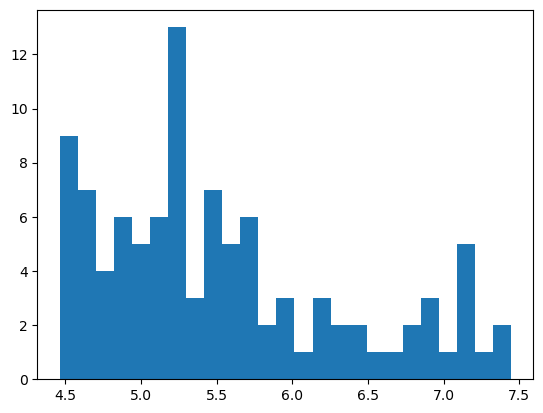

In [11]:
pert_data = np.log(y) + np.random.normal(size=len(y), scale=np.sqrt(sigsq)) 
# np.savetxt("data/blood_donors_gauss_priv.csv", pert_data)
plt.hist(pert_data, bins=25)
plt.show()

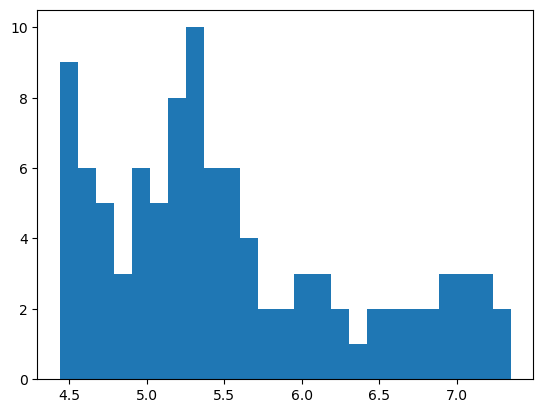

In [12]:
pert_data = np.log(y) + np.random.laplace(size=len(y), scale=eps) 
# np.savetxt("data/blood_donors_laplace_priv.csv", pert_data)
plt.hist(pert_data, bins=25)
plt.show()

In [13]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import default_converter
numpy2ri.activate()
decon = importr("decon")  

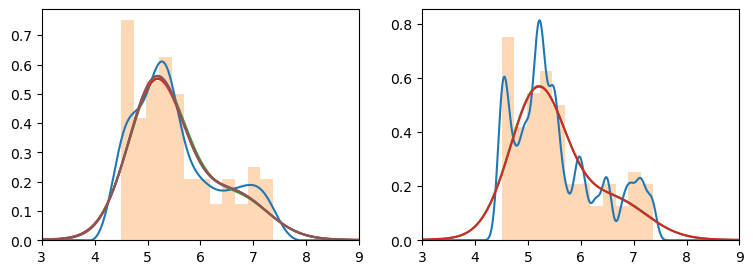

In [16]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

pert_data = np.loadtxt("data/blood_donors_gauss_priv.csv")
sigsq = 0.0036
xgrid = np.linspace(0, 10, 1000)
out = decon.DeconPdf(pert_data, np.sqrt(sigsq), xgrid)[1]
axis[0].plot(xgrid, out, label="Deconv KDE")
axis[0].hist(np.log(y), bins=12, alpha=0.3, density=True)

base_fname = "blood_donors/out/{0}gaussian_eval_dens.csv"
algos = ["privateneal2", "slice", "neal2", "neal3"]
labels = ["Private Neal", "Private Slice", "Neal 2", "Neal 3"]

for i, algo in enumerate(algos):
    dens = pd.read_csv(base_fname.format(algo))
    axis[0].plot(xgrid, np.mean(np.exp(dens), axis=0), label=labels[i])

axis[0].set_xlim(3, 9)

# axis[0].legend(fontsize=15, ncol=3, loc="lower left", bbox_to_anchor=(0.1, -0.45))

pert_data = np.loadtxt("data/blood_donors_laplace_priv.csv")
eps = 0.03
xgrid = np.linspace(0, 10, 1000)

out = decon.DeconPdf(pert_data, eps, xgrid, error="laplacian")[1]
axis[1].plot(xgrid, out, label="Deconv KDE")
axis[1].hist(np.log(y), bins=12, alpha=0.3, density=True)

base_fname = "blood_donors/out/{0}laplace_eval_dens.csv"
algos = ["privateneal2", "slice"]
labels = ["Private Neal", "Private Slice"]

for i, algo in enumerate(algos):
    dens = pd.read_csv(base_fname.format(algo))
    axis[1].plot(xgrid, np.mean(np.exp(dens), axis=0), label=labels[i])

axis[1].set_xlim(3, 9)


plt.savefig("blood_donors/dens_nolegend.png", bbox_inches="tight")
plt.show()

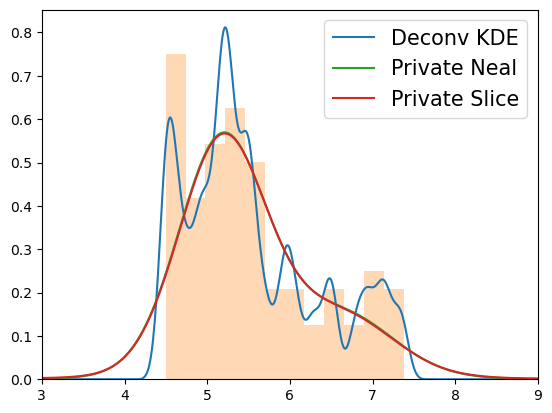

In [46]:
pert_data = np.loadtxt("data/blood_donors_laplace_priv.csv")
eps = 0.03
xgrid = np.linspace(0, 10, 1000)

out = decon.DeconPdf(pert_data, eps, xgrid, error="laplacian")[1]
plt.plot(xgrid, out, label="Deconv KDE")

plt.hist(np.log(y), bins=12, alpha=0.3, density=True)

base_fname = "blood_donors/out/{0}laplace_eval_dens.csv"
algos = ["privateneal2", "slice"]
labels = ["Private Neal", "Private Slice"]

for i, algo in enumerate(algos):
    dens = pd.read_csv(base_fname.format(algo))
    plt.plot(xgrid, np.mean(np.exp(dens), axis=0), label=labels[i])

plt.xlim(3, 9)
plt.legend(fontsize=15)
plt.savefig("blood_donors/dens_lap.pdf", bbox_inches="tight")
plt.show()

In [17]:
np.var(np.log(y))

0.6515842577249724

# Compare Full Posterior Distributions

In [80]:
# run on the confidential dataset

hier_params = "blood_donors/params/nnig_ngg.asciipb"
mix_params = "blood_donors/params/dp_gamma.asciipb"
algo_params = """
algo_id: "Neal3"
rng_seed: 20201124
iterations: 10000
burnin: 5000
"""

In [82]:
eval_dens, nclus, clus, best_clus = run_mcmc(
        hierarchy= "NNIG",
        mixing = "DP",
        data= np.log(y),
        hier_params= hier_params,
        mix_params= mix_params,
        algo_params= algo_params,
        dens_grid= xgrid)

Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running Neal3 algorithm with NNIG hierarchies, DP mixing...
[=================>                                          ] 29% 0.813s                                                                         

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================================] 100% 3.029s                                                                                Done
Computing log-density...
Successfully wrote density to /var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/tmp31bkfxuv/eval_dens.csv
Successfully wrote number of clusters to /var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/tmp31bkfxuv/n_clus.csv
Successfully wrote cluster allocations to /var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/tmp31bkfxuv/clus.csv
Successfully wrote best cluster allocations to /var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/tmp31bkfxuv/best_clus.csv
End of run_mcmc.cc



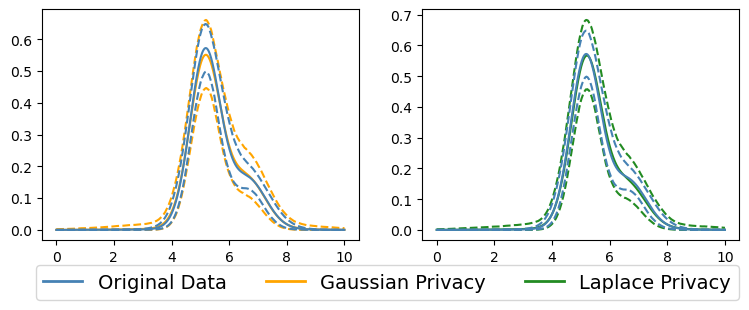

In [86]:
from scipy.stats.mstats import mquantiles
from matplotlib.lines import Line2D


fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

private_dens = np.exp(eval_dens)
private_bands = mquantiles(private_dens, [0.05, 0.95], axis=0)
    
dens = np.exp(pd.read_csv("blood_donors/out/{0}gaussian_eval_dens.csv".format("slice")))
bands = mquantiles(dens, [0.025, 0.975], axis=0)
axis[0].plot(xgrid, np.mean(dens, axis=0), label="Gaussian Privacy", color="orange")
#axis[0].fill_between(xgrid, bands[0, :], private_bands[1, :], alpha=0.3, color="orange")
axis[0].plot(xgrid, bands[0, :], "--", color="orange")
axis[0].plot(xgrid, bands[1, :], "--", color="orange")



dens = np.exp(pd.read_csv("blood_donors/out/{0}laplace_eval_dens.csv".format("slice")))
bands = mquantiles(dens, [0.025, 0.975], axis=0)
axis[1].plot(xgrid, np.mean(dens, axis=0), label="Laplace Privacy", color="forestgreen")
axis[1].plot(xgrid, bands[0, :], "--", color="forestgreen")
axis[1].plot(xgrid, bands[1, :], "--", color="forestgreen")

for i in range(2):
    axis[i].plot(xgrid, np.mean(private_dens, axis=0), label="Original Data", color="steelblue")
    axis[i].plot(xgrid, private_bands[0, :], "--", color="steelblue")
    axis[i].plot(xgrid, private_bands[1, :], "--", color="steelblue")

#axis[0].legend(fontsize=14)
#axis[1].legend(fontsize=14)

legend_lines = [Line2D([0], [0], color="steelblue", lw=2),
                Line2D([0], [0], color="orange", lw=2),
                Line2D([0], [0], color="forestgreen", lw=2)]


axis[1].legend(legend_lines, ['Original Data', 'Gaussian Privacy', 'Laplace Privacy'],
               loc='lower left', ncol=3, fontsize=14, bbox_to_anchor=(-1.25, -0.3))

plt.savefig("blood_donors/dens_comparison.pdf", bbox_inches="tight")